In [1]:
from monte_carlo import *
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [2]:
ndim = 2
nsamples = 1000

target = densities.Camel(ndim)
# add .count attributes to pdf and pot_gradient methods
util.count_calls(target, 'pdf', 'pot_gradient')
start = np.full(ndim, 1/3)

# Markov Updates
The package defines the abstract `MarkovUpdate` which implements a general `sample` function
based on the `next_state(current)` function, that each concrete update must override.
The sample returned is an instance of `MarkovSample` and contains the generated sample as `data`
and provides information such as the mean, variance, and acceptance rate for Metropolis updates.

## Metropolis Updates
Metropolis updates are generally subclasses of `MetropolisUpdate`, which is abstract.
The "default" Metropolis (Hasting) update is implemented in `DefaultMetropolis`.
The metheods, on instantiation, take the sample dimension and a callable target probability
as arguments. The pdf can be a `Density` object, but as opposed to Hamiltonian updates, they
can also be simple functions.

## Default Metropolis Hasting

gotta update pdfGenerated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  0.3218657990000793
pdf calls:  1000
pot_gradient calls:  0


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.50587226 0.50271868],[0.03164832 0.02744347],None,0.117


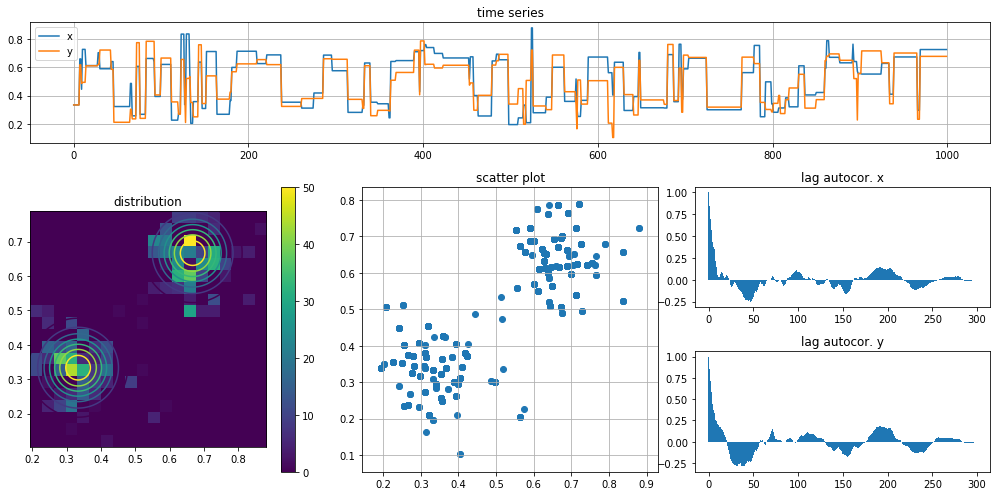

In [4]:
# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

# by default the range for Uniform ins [0, 1]^ndim
proposal = densities.Uniform(ndim)
sampler = DefaultMetropolis(ndim, target.pdf, proposal)

# sample
t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

# print info
print('time: ', t_end - t_start)
print('pdf calls: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample  # show sample

## Adaptive Metropolis

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  0.6466597430007823
pdf calls:  2000
pot_gradient calls:  0


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.49392579 0.5077505 ],[0.03340447 0.03000584],None,0.13


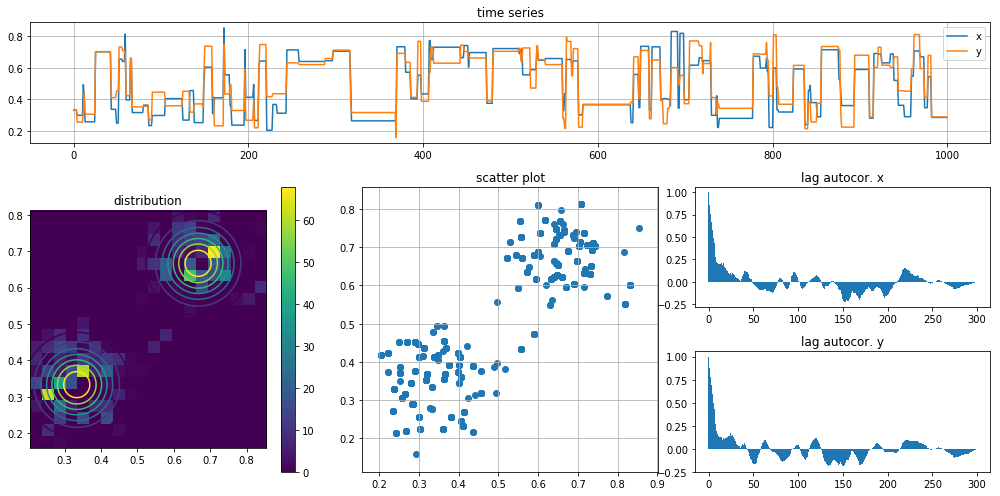

In [11]:
nadapt = 1000
nburnin = 1000

# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

# hast to be a proposal with cov attribute
# this is what adaptive metropolis modifies
proposal = densities.Gaussian(ndim, mu=0.5, cov=0.005)
metropolis_sampler = AdaptiveMetropolisUpdate(
    ndim, target.pdf, proposal, t_initial=100,
    adapt_schedule=lambda t: t <= nadapt)

# burn in
metropolis_sampler.sample(nburnin, [.5, .5], log_every=0)
metropolis_sampler.is_adaptive = False  # turn adaptation off

t_start = timer()
sample = metropolis_sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

print('time: ', t_end - t_start)
print('pdf calls: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

## Hamiltonian Updates
Hamiltonian updates take densities as argument, and therefore don't require a dedicated ndim argument.

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  23.629917145000945
pdf calss:  31969
pot_gradient calls:  30969


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.39688953 0.39416797],[0.02120965 0.02185267],None,0.998


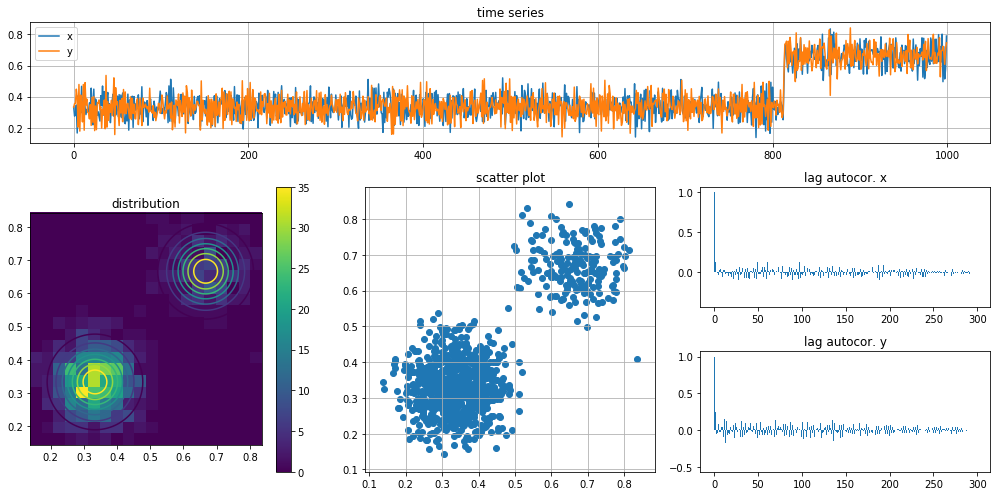

In [12]:
step_size = 0.1
steps = 30

# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

momentum_dist = densities.Gaussian(ndim, scale=10)
sampler = hamiltonian.HamiltonianUpdate(target, momentum_dist, steps, step_size)

t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

print('time: ', t_end - t_start)
print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

## Dual Averaging HMC

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  2.1332121300001745
pdf calss:  3001
pot_gradient calls:  32969


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.34370376 0.34736391],[0.00849391 0.00893691],None,0.458


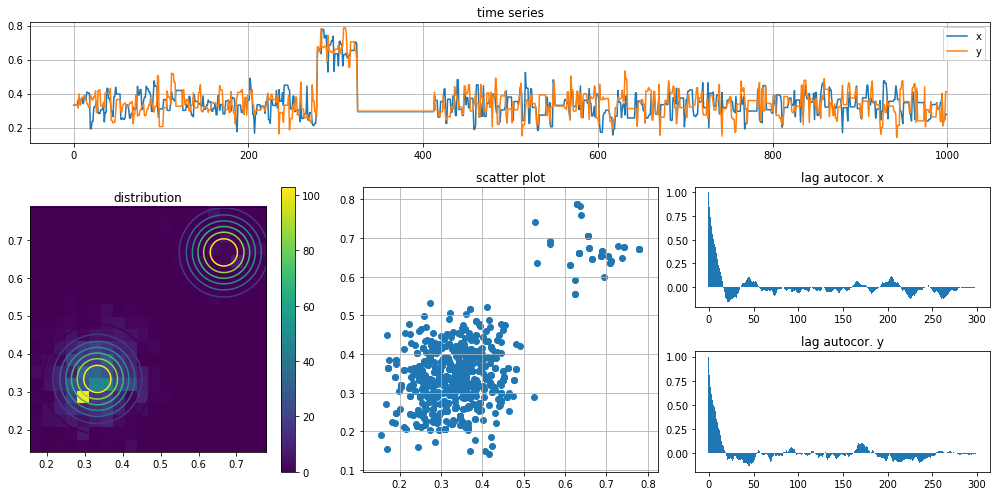

In [13]:
nadapt = 1000

def adapt_schedule(t):
    return t <= nadapt

# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

momentum_dist = densities.Gaussian(ndim, scale=.05)
sampler = hamiltonian.DualAveragingHMC(target, momentum_dist, 1, adapt_schedule)

t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

print('time: ', t_end - t_start)
print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

## No-U-turn sampler

/home/mathis/Dev/bachelor/main/monte_carlo/hamiltonian/nuts.py:83: RuntimeWarning: invalid value encountered in true_divide
  if np.random.uniform() < n_2prime/(n_prime + n_2prime):


Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  24.631912246997672
pdf calss:  44378
pot_gradient calls:  54661


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.33528738 0.33253077],[0.00192208 0.00180334],None,0.954


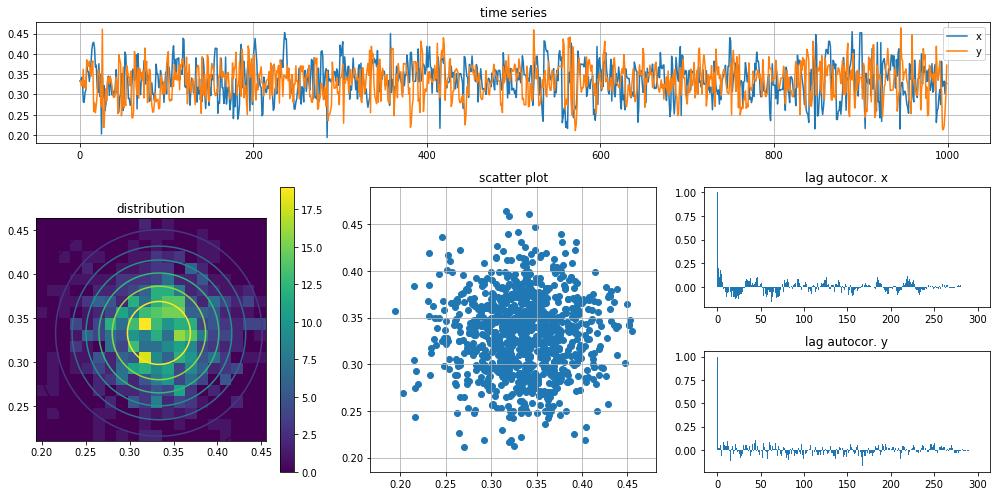

In [14]:
nadapt = 100

def adapt_schedule(t):
    return t <= nadapt

# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

momentum_dist = densities.Gaussian(ndim, scale=50)
sampler = hamiltonian.NUTSUpdate(target, momentum_dist, adapt_schedule)

t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

print('time: ', t_end - t_start)
print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

## Spherical HMC
Sampling is by implementation restrained to $[0, 1]^{ndim}$.

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  6.158279116003541
pdf calss:  9070
pot_gradient calls:  62731


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.5167829 0.49946287],[0.03033089 0.03038786],None,0.388


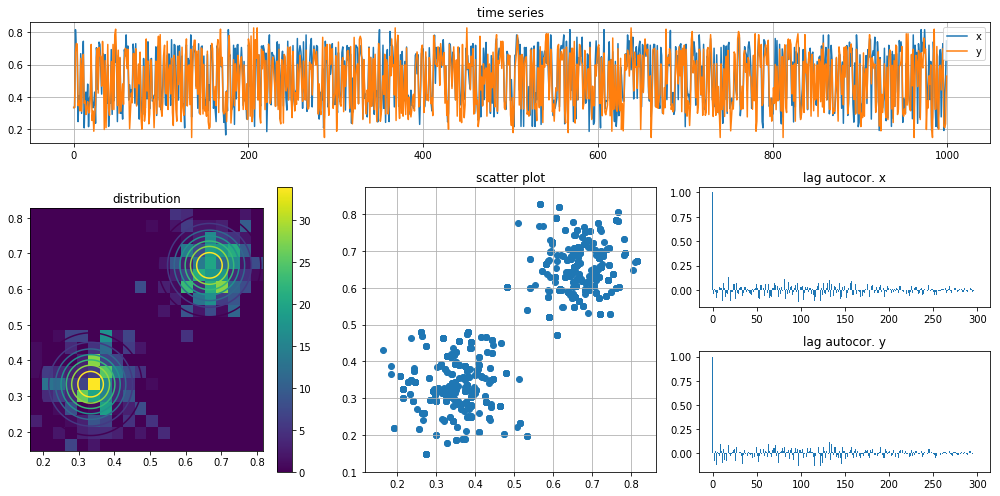

In [15]:
# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

sampler = hamiltonian.StaticSphericalHMC(target, 0.01, 1, 1, 15)

t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

print('time: ', t_end - t_start)
print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

## Spherical NUTS

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
time:  6.904267036999954
pdf calss:  14582
pot_gradient calls:  69520


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.52772517 0.52381861],[0.03068362 0.03132681],None,0.895


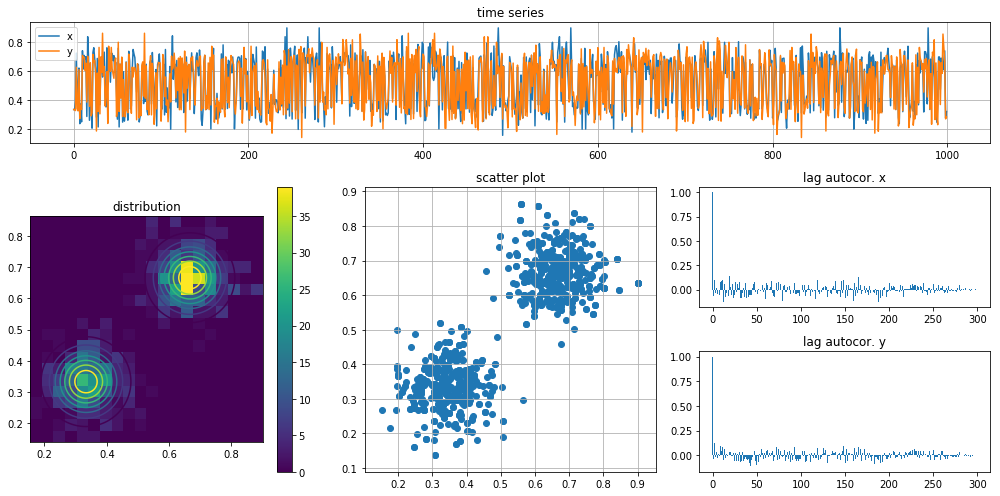

In [16]:
nadapt = 100

def adapt_schedule(t):
    return t <= nadapt

# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

sampler = hamiltonian.SphericalNUTS(target, adapt_schedule)

t_start = timer()
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

print('time: ', t_end - t_start)
print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

# Importance Sampling - Metropolis

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.45943755 0.46506876],[0.04707925 0.04700264],None,0.129


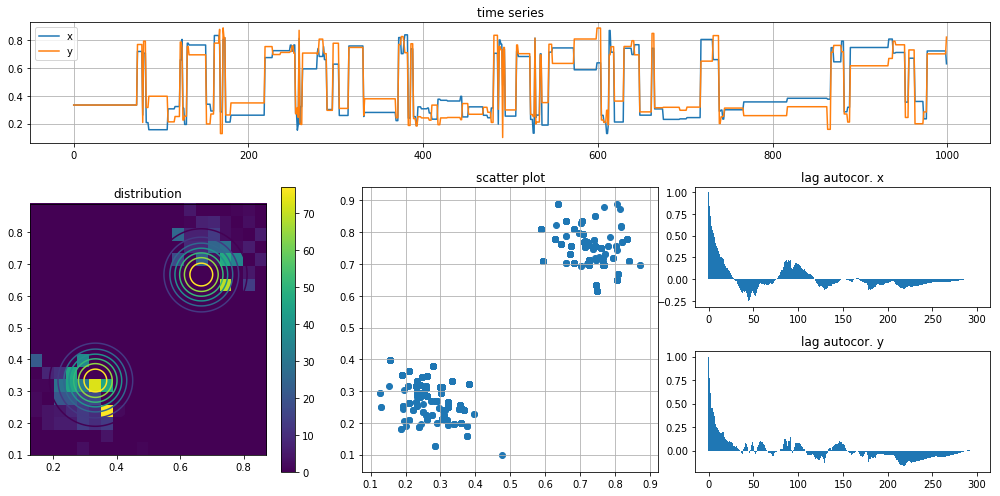

In [17]:
nopt = 1000  # integration steps

# imperfect channels
channels = MultiChannel([
    densities.Gaussian(ndim, mu=1/5, cov=0.005),
    densities.Gaussian(ndim, mu=4/5, cov=0.005)])

# multi channel integrator
importance = MultiChannelMC(channels)

t_start = timer()
integration_sample = importance(target, [], [nopt], []) # integrate

sampler = DefaultMetropolis(ndim, target.pdf, channels)
sample = sampler.sample(nsamples, start, log_every=nsamples/4)
t_end = timer()

sample

## MC 3

Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.53112478 0.50386446],[0.03652469 0.0317018 ],None,0.27


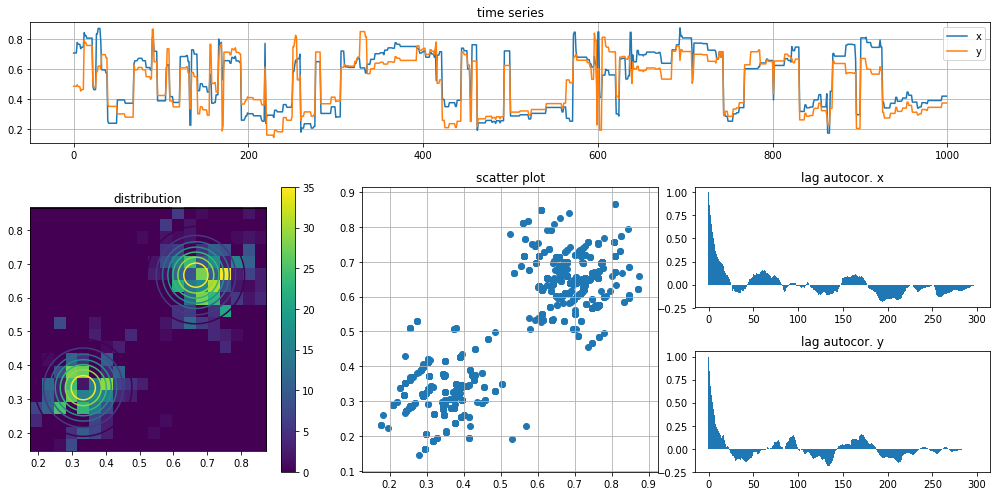

In [18]:
dist = [densities.Gaussian(ndim, mu=np.random.rand(2), scale=0.2) for i in range(10)]
sampler = mc3.MC3Uniform(target, MultiChannel(dist), 0.1, beta=.8)
sample = sampler(([], [1000], []), nsamples)
sample.target = target
sample

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
pdf calss:  9871
pot_gradient calls:  77385


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.55115071 0.55279745],[0.03090658 0.03123275],None,0.749


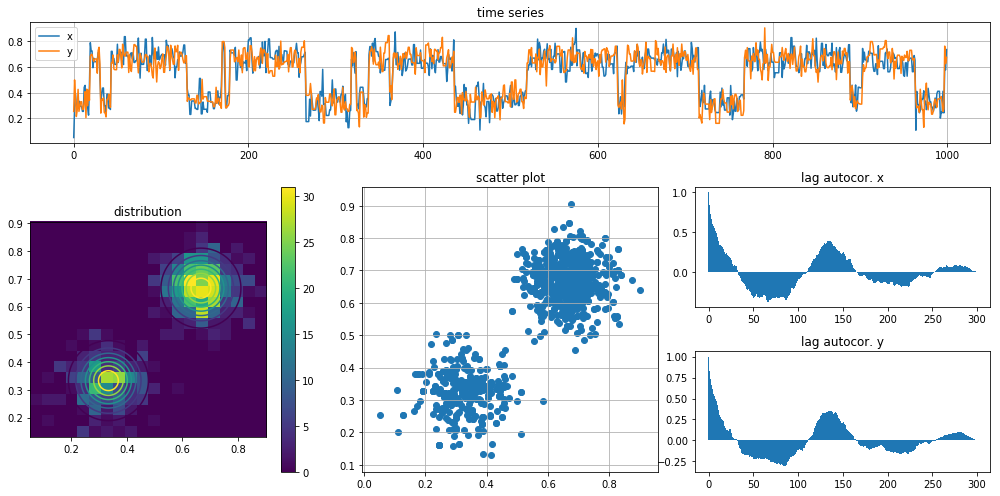

In [19]:
# reset counts
target.pdf.count = 0
target.pdf.pot_gradient = 0

dist = [densities.Gaussian(ndim, mu=np.random.rand(2), scale=0.2) for i in range(10)]
sampler = mc3.MC3Hamilton(target, MultiChannel(dist), 10, 10, .1, beta=.3)
sample = sampler(([], [1000], []), nsamples, log_every=nsamples/4)
sample.target = target

print('pdf calss: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
pdf calls:  49871
pot_gradient calls:  77385


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.58047205 0.58394802],[0.02653875 0.0248918 ],None,0.869


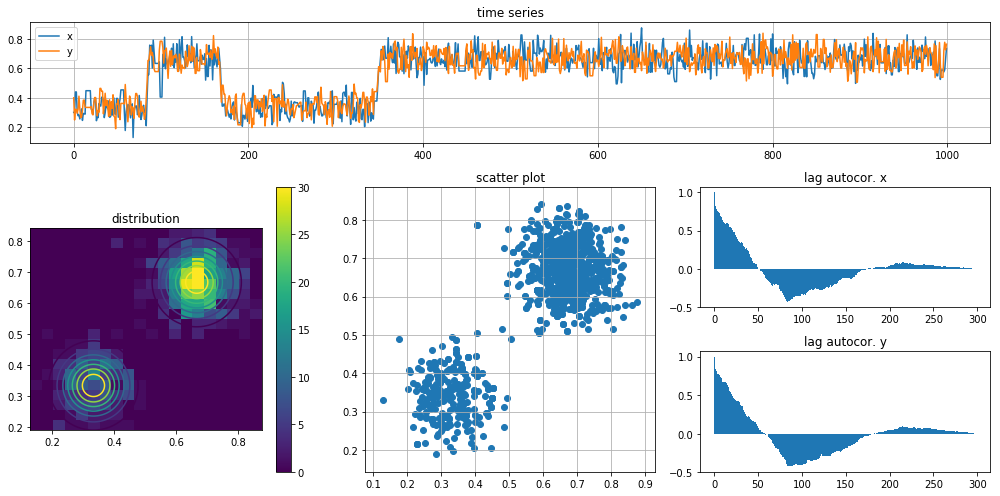

In [20]:
steps = 10
step_size = 0.1
mass = 10
beta = 0
nodes = 1000

# reset counts
target_s = densities.Camel(ndim)

# importance
channels = MultiChannel([densities.Gaussian(ndim, mu=np.random.rand(2), scale=0.2) for i in range(10)])
mc_importance = MultiChannelMC(channels)
integration_sample = mc_importance(target_s, [], [10000], [])

# surrogate
basis = surrogate.extreme_learning.TrigBasis(ndim)
log_vals = -np.ma.log(integration_sample.function_values)
xvals = integration_sample.data[~log_vals.mask]
log_vals = log_vals[~log_vals.mask]

params = basis.extreme_learning_train(xvals, log_vals, nodes)
def surr(xs):
    return basis.eval_gradient(*params, xs)
target_s.pot_gradient = surr


# sampling
p_dist = densities.Gaussian(channels.ndim, scale=mass)
sample_hmc = hamiltonian.HamiltonianUpdate(target_s, p_dist, steps, step_size)

sample_is = DefaultMetropolis(ndim, target_s.pdf, channels)

updates = [sample_is, sample_hmc]
mixing_sampler = MixingMarkovUpdate(ndim, updates, [beta, 1-beta])


sample = mixing_sampler.sample(nsamples, [0.3, 0.4], log_every=nsamples/4)
sample.target = target

print('pdf calls: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

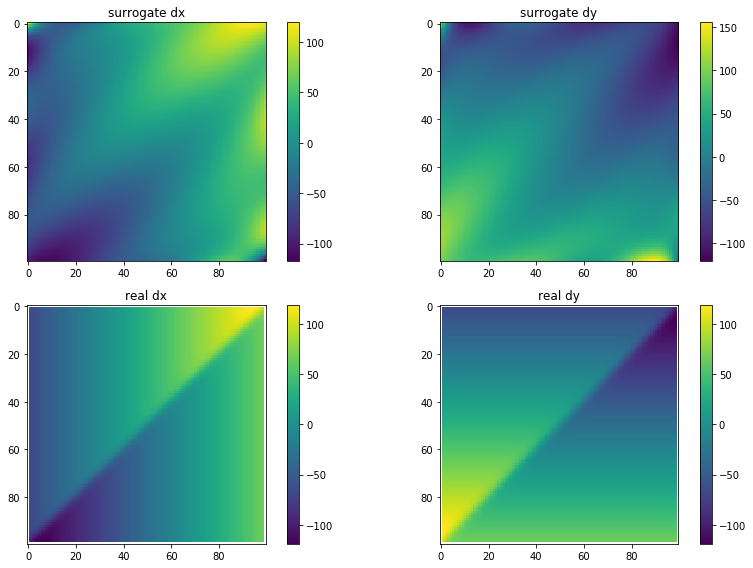

In [21]:
# plot 
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100) 
mgrid = np.meshgrid(x, y)

# fit
out = basis.eval_gradient_split(*params, *mgrid)

plt.figure(figsize=(12,8))
plt.subplot(221)
plt.title("surrogate dx")
plt.imshow(out[:,:,0])
plt.colorbar()

plt.subplot(222)
plt.title("surrogate dy")
plt.imshow(out[:,:,1])
plt.colorbar()

grad = target.pot_gradient(np.stack((mgrid[0].flatten(), mgrid[1].flatten()), axis=0).transpose()).reshape((*mgrid[0].shape, 2))
plt.subplot(223)
plt.title("real dx")
plt.imshow(grad[:,:,0])
plt.colorbar()

plt.subplot(224)
plt.title("real dy")
plt.imshow(grad[:,:,1])
plt.colorbar()

plt.tight_layout()
plt.show()

Generated 250 samples.
Generated 500 samples.
Generated 750 samples.
Generated 1000 samples.
pdf calls:  99871
pot_gradient calls:  87385


Data (size),mean,variance,effective sample size,acceptance rate
1000,[0.43495902 0.43138638],[0.02749506 0.02765811],None,0.888


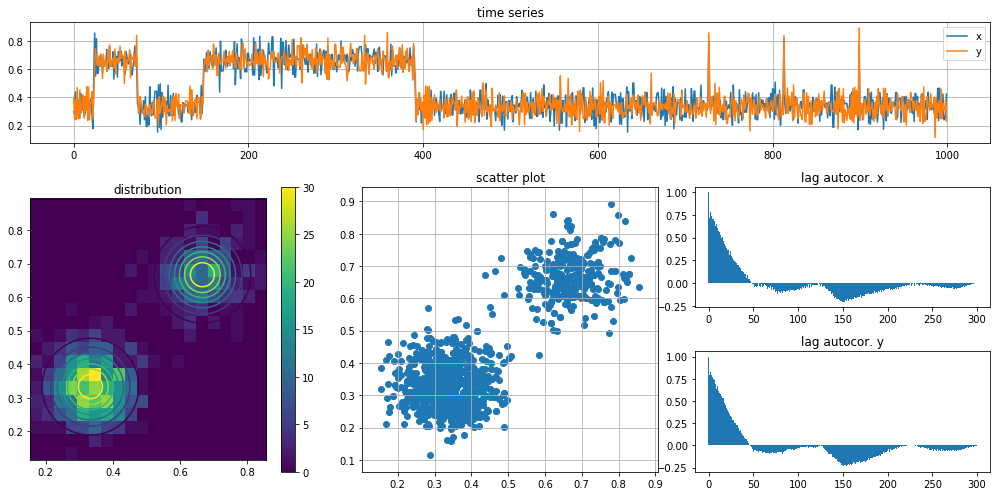

In [22]:
steps = 30
step_size = 0.1
mass = 10
beta = 0.1
nodes = 1000

# reset counts
target_s = densities.Camel(ndim)

# importance
channels = MultiChannel([densities.Gaussian(ndim, mu=np.random.rand(2), scale=0.2) for i in range(10)])
mc_importance = MultiChannelMC(channels)
integration_sample = mc_importance(target_s, [], [10000], [])

# surrogate
basis = surrogate.extreme_learning.GaussianBasis(ndim)
log_vals = -np.ma.log(integration_sample.function_values)
xvals = integration_sample.data[~log_vals.mask]
log_vals = log_vals[~log_vals.mask]

params = basis.extreme_learning_train(xvals, log_vals, nodes)
def surr(xs):
    return basis.eval_gradient(*params, xs)
target_s.pot_gradient = surr


# sampling
p_dist = densities.Gaussian(channels.ndim, scale=mass)
sample_hmc = hamiltonian.HamiltonianUpdate(target_s, p_dist, steps, step_size)

sample_is = DefaultMetropolis(ndim, target_s.pdf, channels)

updates = [sample_is, sample_hmc]
mixing_sampler = MixingMarkovUpdate(ndim, updates, [beta, 1-beta])


sample = mixing_sampler.sample(nsamples, [0.3, 0.4], log_every=nsamples/4)
sample.target = target

print('pdf calls: ', target.pdf.count)
print('pot_gradient calls: ', target.pot_gradient.count)
sample

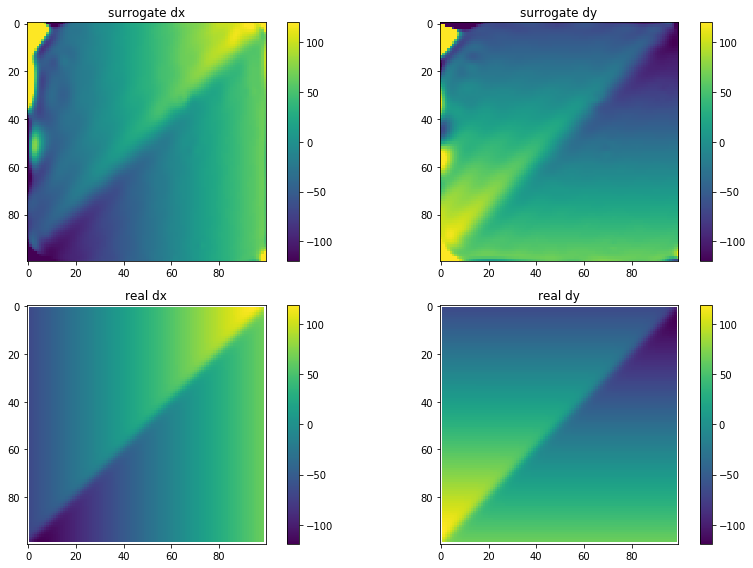

In [23]:
# plot 
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100) 
mgrid = np.meshgrid(x, y)

# fit
out = basis.eval_gradient_split(*params, *mgrid)

plt.figure(figsize=(12,8))
plt.subplot(221)
plt.title("surrogate dx")
plt.imshow(out[:,:,0], vmin=-120, vmax=120)
plt.colorbar()

plt.subplot(222)
plt.title("surrogate dy")
plt.imshow(out[:,:,1], vmin=-120, vmax=120)
plt.colorbar()

grad = target.pot_gradient(np.stack((mgrid[0].flatten(), mgrid[1].flatten()), axis=0).transpose()).reshape((*mgrid[0].shape, 2))
plt.subplot(223)
plt.title("real dx")
plt.imshow(grad[:,:,0])
plt.colorbar()

plt.subplot(224)
plt.title("real dy")
plt.imshow(grad[:,:,1])
plt.colorbar()

plt.tight_layout()
plt.show()